In [97]:
import pathlib as pl
from configparser import ConfigParser
from math import factorial
import itertools as itt

import joblib as jl
import numpy as np
import scipy.stats as sst
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from src.data.load import load
from src.visualization.interactive import plot_raw_pair
from src.root_path import config_path
from src.visualization.palette import *

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [98]:
def plot_pupil_effect(cellid, contexts, probe):

    big = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR, pupil='small')['data']
    small = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR, pupil='big')['data']

    fig = make_subplots(rows=2, cols=2, shared_yaxes='rows', shared_xaxes=False,
                        subplot_titles=['small', 'big', 'raw pupil trace'],

                        specs=[[{}, {}],
                               [{'colspan':2},None]]

                        )

    # add psth traces to the suboplots
    _ = fig.add_traces(small, rows=[1]*len(small), cols=[1]*len(small))
    _ = fig.update_traces(showlegend=False)

    _ = fig.add_traces(big, rows=[1]*len(big), cols=[2]*len(big))

    # vertical lines of probe onset
    for cc in range(2):
        _ = fig.add_vline(x=0, line=dict(color='black',
                                     dash='dot'),
                      row=1, col=cc+1)

    # raw pupil trace
    recs, _ = load(cellid.split('-')[0], rasterfs=20, recache=False, pupil=True)
    pupil_trace = recs['perm0']['pupil']._data.squeeze(axis=0)
    t = np.linspace(0,pupil_trace.size/20, pupil_trace.size, endpoint=False)

    _ = fig.add_trace(go.Scatter(x=t, y=pupil_trace, mode='lines',
                                 line=dict(color='black'),
                                 showlegend=False),
                  row=2, col=1)

    _ = fig.add_hline(y=np.median(pupil_trace),
                      line=dict(color='gray',
                                dash='dot'),
                      row=2, col=1)

    fig.update_layout(margin=dict(l=10, r=10, t=50, b=10),)

    return fig

# new plan
1. find neurons with significant pupil first order effects, i.e. effects on firing rate (not on deltas or context stuff)
2. There is no need to do split the probe response by time, use full length
3. There is no need to keep track of contex information, aggregate by neuron and probe
4. plot the histograms for modulation coefficient for each site
5. the histogram can potentially aggregate by each neuron mean

## First order first

In [99]:
# New firing rates, the file is a misnomer, it has not deltas
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220801_pupil_delta_firerates'
first_ord_DF = jl.load(fr_DF_file
                ).query("part == 'probe' and chunk == 'full' and pupil != 'full'"
                        ).drop(columns=['chunk', 'part', 'metric']
                               ).reset_index(drop=True)
# reduces size with adecuate data  typing
m0 = first_ord_DF.memory_usage(deep=True).sum()

for col in ['id', 'site', 'pupil', 'probe', 'context']:
    first_ord_DF[col] = first_ord_DF[col].astype('category')

# for col in ['probe', 'context']:
#     first_ord_DF[col] = pd.to_numeric(first_ord_DF[col], downcast='unsigned')

first_ord_DF['value'] = pd.to_numeric(first_ord_DF['value'], downcast='float')

print(f"DF reduced to {first_ord_DF.memory_usage(deep=True).sum() / m0 *100:0.2f}% of original size!")
first_ord_DF = first_ord_DF.groupby(['id', 'site', 'probe', 'pupil'],
                                    observed=True, dropna=True).agg(value=('value',np.nanmean)).reset_index()

print(first_ord_DF.shape)
first_ord_DF.head()

DF reduced to 4.97% of original size!
(22896, 5)


id     site probe  pupil     value
0  CRD018d-01-1  CRD018d     1  small  0.436553
1  CRD018d-01-1  CRD018d     1    big  0.708697
2  CRD018d-01-1  CRD018d     2  small -0.040089
3  CRD018d-01-1  CRD018d     2    big  0.178443
4  CRD018d-01-1  CRD018d     3  small -0.253035

In [100]:
pivoted = first_ord_DF.pivot_table(index=['id','site','probe',],
                                   columns='pupil', values='value',
                                   dropna=True, observed=True).reset_index().copy()
pivoted['mod_coeff'] = (pivoted['big'] - pivoted['small']) /  (pivoted['big'] + pivoted['small'])
pivoted['abs_mod_coeff'] = np.abs(pivoted['mod_coeff'])

pivoted.head()

pupil            id     site probe       big     small  mod_coeff  \
0      CRD018d-01-1  CRD018d     1  0.708697  0.436553   0.237629   
1      CRD018d-01-1  CRD018d     2  0.178443 -0.040089   1.579518   
2      CRD018d-01-1  CRD018d     3 -0.170345 -0.253035  -0.195309   
3      CRD018d-01-1  CRD018d     4  0.168039  0.007177   0.918074   
4      CRD018d-05-1  CRD018d     1 -0.126569 -0.121765   0.019344   

pupil  abs_mod_coeff  
0           0.237629  
1           1.579518  
2           0.195309  
3           0.918074  
4           0.019344

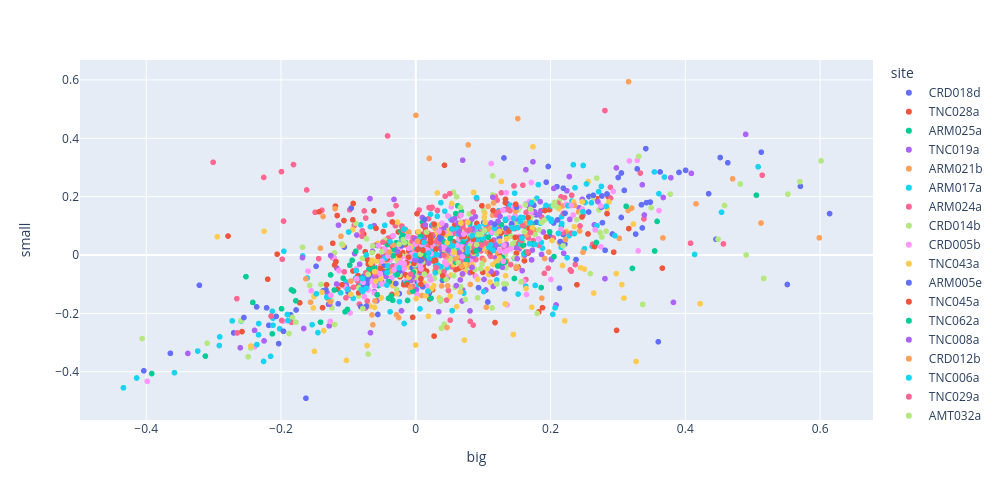

In [101]:
toplot = pivoted.query(f"abs_mod_coeff < {pivoted.abs_mod_coeff.quantile(.95)}")
toplot = toplot.groupby(['id', 'site'], observed=True, dropna=True).agg('mean').reset_index()

fig = px.scatter(toplot,x='big',y='small', color='site', hover_name='id')

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)
# fig.show()

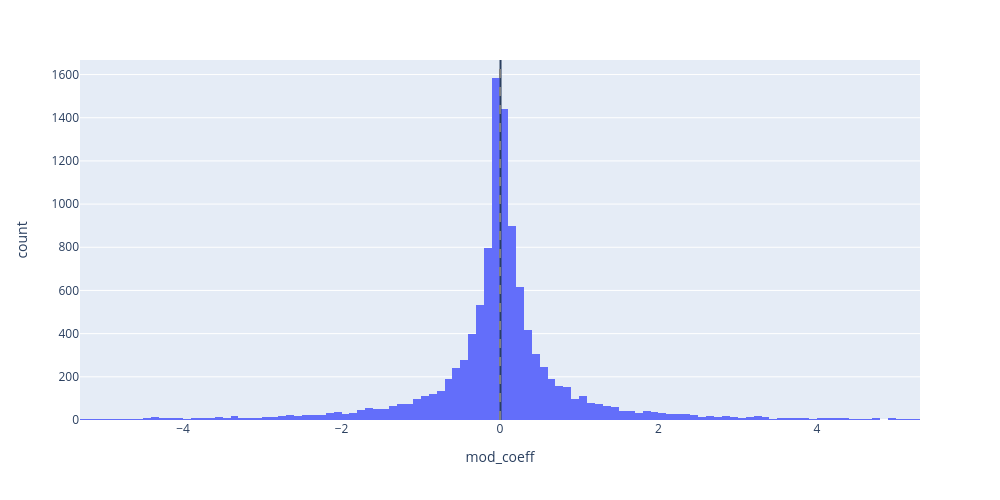

In [102]:
toplot = pivoted.query(f"abs_mod_coeff < {pivoted.abs_mod_coeff.quantile(.95)}")

fig = px.histogram(toplot, x='mod_coeff')
fig.add_vline(x=toplot.mod_coeff.mean())
fig.add_vline(x=0, line_color='gray', line_dash='dash')

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

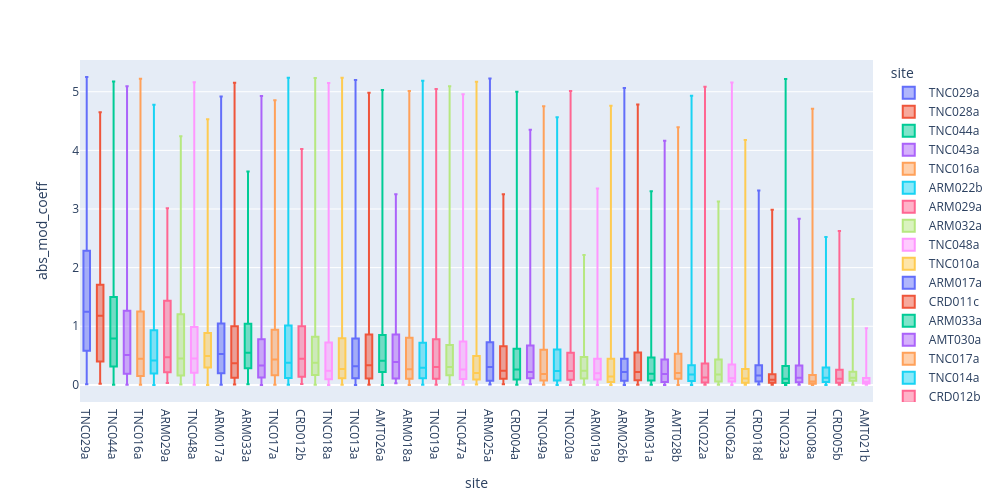

In [103]:
# split by site
# gets sites sorted by mean abs_mod_coeff
site_sorter = toplot.groupby('site', observed=True, dropna=True
                        ).agg('mean'
                              ).sort_values(by='abs_mod_coeff', ascending=False
                                            ).index.tolist()


fig = px.box(toplot,x='site',y='abs_mod_coeff', color='site', points=False,
             category_orders={'site':site_sorter}
             )

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

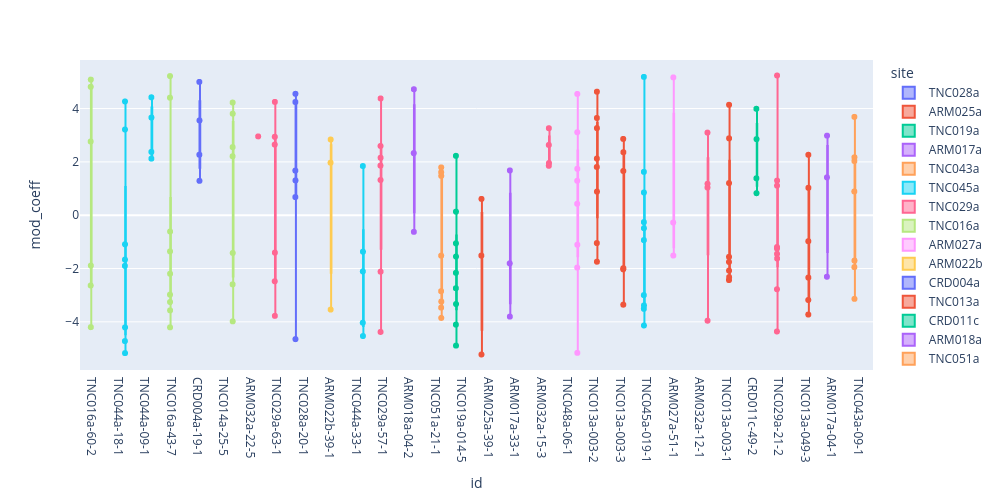

In [104]:
# split by cell
# gets sites sorted by mean abs_mod_coeff
cell_sorter = toplot.groupby('id', observed=True, dropna=True
                        ).agg('mean'
                              ).sort_values(by='abs_mod_coeff', ascending=False
                                            ).index.tolist()

# plots only top n neurons

fig = px.box(toplot.query(f"id in {cell_sorter[:30]}"),
             x='id',y='mod_coeff', color='site', points='all',
             category_orders={'id':cell_sorter}
             )

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

In [105]:
# probe nature changes de modulation response in neurons. i.e. neurons are inconsistent
toplot = pivoted.query(f"id in {cell_sorter[:30]}")

fig = px.scatter(toplot,x='big',y='small', color='site', hover_name='id')
# img_bytes = fig.to_image(format="png", width=500, height=500)
# Image(img_bytes)
fig.show()

In [106]:
# cleanup
del(toplot, pivoted, first_ord_DF)

### site trends!
Against initial observations, it seems that sites are consistent in their modulation.
i.e. neurons belonging to the same site tend to either be up or down modulated together
that being said, there is a lot of poorly modulated neurons across all sites
Furthermore, this is more readily  visible on the big vs small space and not on the modulation index.

# Second order effects

having found a handful of neurons that are worth looking at, now try to determine the effect of these big pupil
changes in the contextual modulation.
1. get second order data i.e. delta FR as a funcion of pupil size
2. taking care of flippign delta FR so all are possitive for the pupil independent fr
3. properly casting the data types to save e on memory
4. filter by signiricant instancese
5. order by first order effects
6. plotting only the best examples

In [107]:
# New firing rates, the file is a misnomer, it has not deltas
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220801_pupil_delta_firerates'
second_ord_DF = jl.load(fr_DF_file
                ).query("part == 'probe'"
                        ).drop(columns=['part', 'metric']
                               ).reset_index(drop=True)

m0 = second_ord_DF.memory_usage(deep=True).sum()

for col in ['id', 'site', 'pupil', 'probe', 'context', 'chunk']:
    second_ord_DF[col] = second_ord_DF[col].astype('category')

second_ord_DF['value'] = pd.to_numeric(second_ord_DF['value'], downcast='float')

print(f"DF reduced to {second_ord_DF.memory_usage(deep=True).sum() / m0 *100:0.2f}% of original size!")

print(second_ord_DF.shape)
second_ord_DF.head()


# Calculate delta firing rate for pairs of contexts
second_ord_DF = second_ord_DF.pivot_table(index=['id', 'site', 'chunk', 'probe', 'pupil'], columns=['context'],
                                   values='value', aggfunc='first', dropna=True, observed=True)

n_comb = int(factorial(second_ord_DF.shape[1]) /
             (2 * factorial(second_ord_DF.shape[1] - 2)))
ctx_pair_R = np.full((second_ord_DF.shape[0], n_comb), np.nan)
new_cols = list()
for pr_idx, (c0, c1) in enumerate(itt.combinations(second_ord_DF.columns, r=2)):
    new_cols.append(f'{c0:02}_{c1:02}')
    ctx_pair_R[:, pr_idx] = second_ord_DF.values[:, c0] - second_ord_DF.values[:, c1]

# Melts back into long format and ensures column typing for memory efficiency
second_ord_DF = pd.DataFrame(index=second_ord_DF.index, columns=new_cols, data=ctx_pair_R
                      ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()
second_ord_DF['context_pair'] = second_ord_DF['context_pair'].astype('category')

print(second_ord_DF.memory_usage(deep=True))
print(second_ord_DF.dtypes)
print(second_ord_DF.shape)
second_ord_DF.head()

DF reduced to 4.01% of original size!
(1624050, 7)
Index                128
id              15085136
site             7460580
chunk            7455165
probe            7455080
pupil            7454991
context_pair     7460214
delta_fr        59637600
dtype: int64
id              category
site            category
chunk           category
probe           category
pupil           category
context_pair    category
delta_fr         float64
dtype: object
(7454700, 7)


id     site chunk probe  pupil context_pair  delta_fr
0  CRD018d-01-1  CRD018d     A     1  small        00_01  0.271619
1  CRD018d-01-1  CRD018d     A     1    big        00_01 -0.073563
2  CRD018d-01-1  CRD018d     A     1   full        00_01  0.108647
3  CRD018d-01-1  CRD018d     A     2  small        00_01  0.029102
4  CRD018d-01-1  CRD018d     A     2    big        00_01 -0.282936

In [108]:
pivoted = second_ord_DF.pivot_table(index=['id', 'site', 'context_pair', 'probe', 'chunk'],
                                   columns='pupil', values='delta_fr', aggfunc='first',
                                   dropna=True, observed=True).reset_index()

# flips firing rates
flipper = (pivoted.full.values > 0) * 2 - 1
pivoted['small'] = pivoted['small'] * flipper
pivoted['big'] = pivoted['big'] * flipper
pivoted['full'] = pivoted['full'] * flipper

pivoted['mod_coeff'] = (pivoted['big'] - pivoted['small']) /  (pivoted['big'] + pivoted['small'])
pivoted['abs_mod_coeff'] = np.abs(pivoted['mod_coeff'])

# some instances of zero FR and no difference between pupils leads to nan and inf mod_coeff, removes those rows
pivoted.replace([-np.inf, np.inf], np.nan, inplace=True)
pivoted.dropna(axis='index', inplace=True)

print(pivoted.shape)
pivoted.head()

(2405836, 10)


pupil            id     site context_pair probe chunk       big      full  \
0      CRD018d-01-1  CRD018d        00_01     1     A -0.073563  0.108647   
1      CRD018d-01-1  CRD018d        00_01     1     B  0.039611  0.081486   
2      CRD018d-01-1  CRD018d        00_01     1     C  0.181079  0.081486   
3      CRD018d-01-1  CRD018d        00_01     1     D  0.384793  0.461752   
4      CRD018d-01-1  CRD018d        00_01     1  full  0.042440  0.142600   

pupil     small  mod_coeff  abs_mod_coeff  
0      0.271619  -1.742857       1.742857  
1      0.077605  -0.324138       0.324138  
2     -0.019401   1.240000       1.240000  
3      0.533536  -0.161972       0.161972  
4      0.225540  -0.683258       0.683258

### filter for contextual significance

In [130]:
 # Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_chunked_amplitude_DF'

metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D',]
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF['chunk'] = DF['metric'].str.split('_').str[-1]
DF.loc[:,'chunk'].replace({'integral': 'full'}, inplace=True)

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'metric', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)

for col in ['id','context_pair','probe','site', 'region', 'chunk']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
DF.head()

id context_pair probe       value     site region chunk
0  AMT029a-35-1        00_01     1  540.689758  AMT029a    PEG  full
1  AMT029a-43-1        00_01     1  542.716431  AMT029a    PEG  full
2  AMT029a-48-1        00_01     1  432.214355  AMT029a    PEG  full
3  AMT029a-51-1        00_01     1  358.975830  AMT029a    PEG  full
4  AMT029a-57-1        00_01     1  336.460602  AMT029a    PEG  full

In [132]:
pivoted.id.unique().shape

(1585,)

In [135]:
# taking the top 10% pupil modulated neurons
toplot = pd.merge(pivoted.query(f"id in {cell_sorter[:158]}"),
                  DF, on=['id', 'site', 'context_pair', 'probe', 'chunk'],
                  validate='m:1')

print(toplot.shape)
toplot.head()

(1805, 12)


id     site context_pair probe chunk       big      full  \
0  TNC028a-08-1  TNC028a        02_09     7     B  0.669146  0.690057   
1  TNC028a-08-1  TNC028a        02_09     7  full  0.572956  0.507192   
2  TNC028a-08-1  TNC028a        03_09     7     A  0.850373  0.579648   
3  TNC028a-08-1  TNC028a        03_09     7     B  0.822492  0.897074   
4  TNC028a-08-1  TNC028a        03_09     7  full  0.741637  0.634852   

      small  mod_coeff  abs_mod_coeff       value region  
0  0.739894  -0.050210       0.050210  511.543915    PEG  
1  0.457163   0.112408       0.112408  511.543915    PEG  
2  0.331785   0.438679       0.438679  386.570648    PEG  
3  0.931228  -0.062003       0.062003  571.252563    PEG  
4  0.476766   0.217391       0.217391  957.823181    PEG

In [138]:
# quick and dirty scatter, mean for each neuron
# toplot = pivoted.query(f"id in {cell_sorter[:100]}").groupby(['id', 'site', 'chunk'], observed=True,).agg(np.nanmean).reset_index()


fig = px.scatter(toplot, x='big', y='small', color='site', facet_col='chunk',
                 category_orders={'chunk':['A','B','C','D','full']})

# img_bytes = fig.to_image(format="png", width=1000, height=500)
# Image(img_bytes)

fig.show()

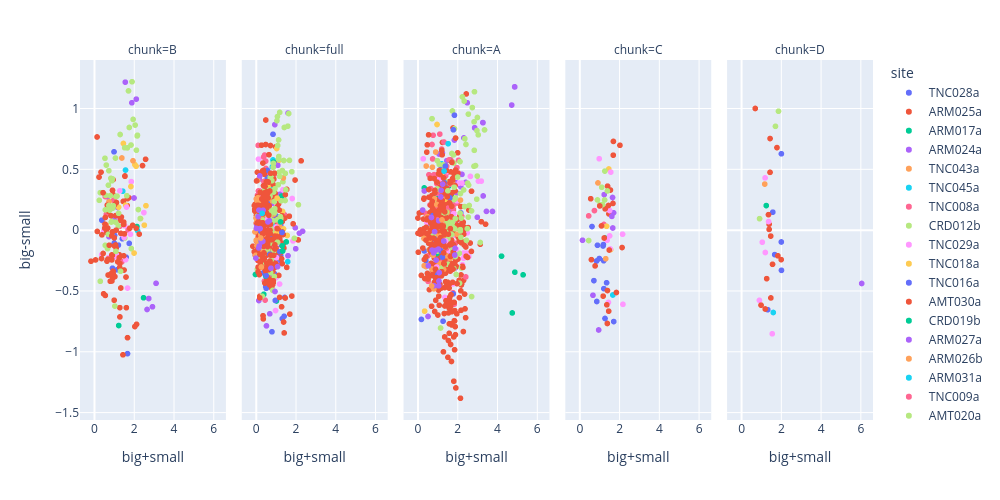

In [139]:
toplot['big+small'] = toplot['big'] + toplot['small']
toplot['big-small'] = toplot['big'] - toplot['small']

fig = px.scatter(toplot, x='big+small', y='big-small', color='site', facet_col='chunk')
img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

In [87]:
# melt back the pupil related clasification for easy hist plotting
molten = pivoted.melt(id_vars=['id','site','context_pair','probe','chunk'],
                      value_vars=['small','big','full','mod_coeff', 'abs_mod_coeff'],
                      var_name='pupil')
molten['pupil'] = molten['pupil'].astype('category')

In [89]:
toplot = molten.query("pupil in ['small', 'big', 'full'] and chunk != 'full'")
print(toplot.shape)
toplot.head()

(5735409, 7)


id     site context_pair probe chunk  pupil     value
0  CRD018d-01-1  CRD018d        00_01     1     A  small  0.271619
1  CRD018d-01-1  CRD018d        00_01     1     B  small  0.077605
2  CRD018d-01-1  CRD018d        00_01     1     C  small -0.019401
3  CRD018d-01-1  CRD018d        00_01     1     D  small  0.533536
5  CRD018d-01-1  CRD018d        00_01     2     A  small -0.029102

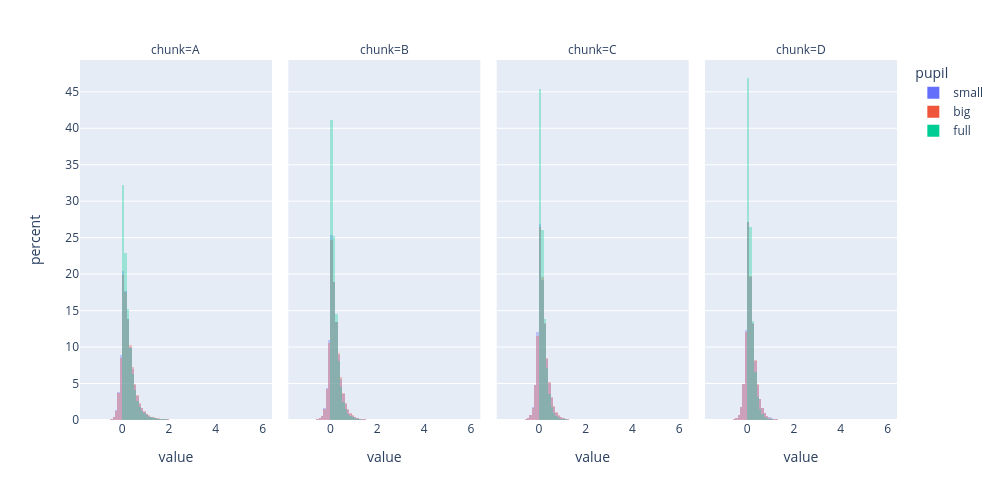

In [90]:
fig = px.histogram(toplot, x='value', color='pupil', histnorm='percent',
                   nbins=100, opacity=1/3, barmode='overlay',
                   facet_col='chunk')

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

### filter by context effects


In [ ]:

fig = go.Figure()
for source, color in zip(['big_flip', 'small_flip', 'pupil_diff'],
                         [Blue, Orange, 'black']):
    x = toplot[source]
    m = np.mean(x)
    _ = fig.add_trace(go.Histogram(x=x, marker=dict(color=color,
                                                line_width=0,
                                                opacity=0.5),
                               name=source,
                               nbinsx=100,
                               histnorm='percent'))
    _ = fig.add_vline(x=m, line=dict(color=color, dash='dot', width=1), opacity=1)

_ = fig.add_vline(x=0, line=dict(color='gray',width=2, dash='solid'))

_ = fig.update_layout(margin=dict(l=10,r=10,t=10,b=10),
                  template='simple_white',
                  barmode='overlay')


img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

# Summary across all sites
select and compare only significant instances

In [2]:
def get_filter_DF():
    # Cluster Mass significant contextual effects
    summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_chunked_amplitude_DF'

    metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D',
               # 'mass_center', 'last_bin',
               ]
    DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                        f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                        f"analysis == 'SC' and "
                                        f"value > 0 and value < 10000")
    DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr', 'analysis'], inplace=True)

    DF['chunk'] = DF['metric'].str.split('_').str[-1]
    DF.loc[:,'chunk'].replace({'integral': 'full'}, inplace=True)

    # uses contextual effect magnitude as a rough filter
    chunks = DF.query("chunk != 'full'").copy()
    chunks['quality'] = pd.qcut(chunks['value'].astype(float), q=4, labels=['worst', 'bad', 'good', 'best'])

    # since qualiti depends on an integral, and the full lengh will have longer integrals, classifies on its own
    full = DF.query("chunk == 'full'").copy()
    full['quality'] = pd.qcut(full['value'].astype(float), q=4, labels=['worst', 'bad', 'good', 'best'])

    filter_df =  pd.concat([chunks, full])

    return filter_df

filter_df = get_filter_DF()

In [3]:
def get_dfr_DF():
    # New firing rates, the file is a misnomer, it has not deltas
    fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220801_pupil_delta_firerates'
    DF_fr = jl.load(fr_DF_file)

    # Calculate delta firing rate for pairs of contexts
    DF_dfr = DF_fr.query("part == 'probe'"
                         ).pivot_table(index=['id', 'site', 'chunk', 'probe', 'pupil'], columns=['context'],
                                       values='value', aggfunc='first')

    n_comb = int(factorial(DF_dfr.shape[1]) /
                 (2 * factorial(DF_dfr.shape[1] - 2)))
    ctx_pair_R = np.full((DF_dfr.shape[0], n_comb), np.nan)
    new_cols = list()
    for pr_idx, (c0, c1) in enumerate(itt.combinations(DF_dfr.columns, r=2)):
        new_cols.append(f'{c0:02}_{c1:02}')
        ctx_pair_R[:, pr_idx] = DF_dfr.values[:, c0] - DF_dfr.values[:, c1]

    DF_dfr = pd.DataFrame(index=DF_dfr.index, columns=new_cols, data=ctx_pair_R
                          ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()
    return DF_dfr
DF_dfr = get_dfr_DF()

In [4]:
pupil_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220802_pupil_summary_DF'
pup_df = jl.load(pupil_DF_file)
pup_df

site        CV pupil_quality
2   CRD012b  0.931146          best
16  AMT032a  0.799976          best
37  TNC051a  0.602092          best
46  ARM019a  0.453658          best
29  TNC044a  0.435534          best
19  TNC048a  0.427811          best
53  AMT029a  0.416662          best
23  ARM023a  0.403069          best
50  ARM021b  0.400226          best
40  ARM024a  0.370095          best
32  TNC029a  0.369574          best
30  CRD018d  0.368401          best
44  AMT028b  0.368290          best
42  TNC006a  0.363441          best
54  AMT026a  0.347430          best
25  ARM028b  0.345126          good
52  AMT020a  0.340626          good
51  ARM025a  0.332295          good
15  ARM022b  0.323043          good
22  AMT030a  0.321905          good
11  TNC047a  0.318160          good
35  ARM026b  0.313242          good
28  TNC050a  0.285214          good
0   ARM017a  0.283674          good
38  ARM033a  0.276386          good
57  TNC028a  0.273833          good
13  ARM027a  0.265971          good
14  ARM032a  0.264462          good
33  TNC017a  0.262816          good
47  TNC016a  0.260617           bad
45  TNC014a  0.257660           bad
8   TNC024a  0.246355           bad
49  TNC022a  0.242756           bad
21  TNC043a  0.238485           bad
31  ARM018a  0.222308           bad
5   TNC021a  0.219384           bad
34  ARM029a  0.191728           bad
48  ARM031a  0.191691           bad
39  CRD011c  0.190629           bad
56  CRD014b  0.182908           bad
24  TNC023a  0.180856           bad
4   TNC013a  0.177695           bad
10  TNC019a  0.177668           bad
17  TNC045a  0.173881           bad
26  CRD004a  0.173771         worst
18  TNC018a  0.171244         worst
12  TNC010a  0.165672         worst
9   TNC009a  0.165174         worst
3   TNC012a  0.158614         worst
7   ARM005e  0.157193         worst
6   TNC049a  0.155630         worst
43  TNC008a  0.152783         worst
36  AMT021b  0.150972         worst
27  TNC015a  0.147972         worst
55  CRD005b  0.147419         worst
58  TNC020a  0.146430         worst
20  TNC062a  0.141301         worst
41  CRD019b  0.133547         worst
1   TNC011a  0.113156         worst

## compare context effects by pupil

In [5]:
# filters data for significant instanceses
# this merge is way too big. should do it by parts. in particular chunks and pupil states.
# you can run it by liberating resourcese in your computer. Cacheing for convenience
filt_dfr_pupil = pl.Path(config['paths']['analysis_cache']) / f'220803_filtered_pupil_dfr_deleteme!'

recache_merge = False
if filt_dfr_pupil.exists() and not recache_merge:
    print('loading cache...')
    merged = jl.load(filt_dfr_pupil)
    print('done!')

else:
    print('running merge anew, This might crash the computer')
    merged = pd.merge(DF_dfr, filter_df.loc[:,['id', 'context_pair', 'probe', 'chunk', 'quality']],
                      on=['id', 'context_pair', 'probe', 'chunk'],
                      validate='m:1')
    jl.dump(merged, filt_dfr_pupil)
    print('done!')

loading cache...
done!


In [6]:
pupil_quality = ['best']
mod_quality = ['best','good','bad','worst']
chunks = ['A', 'B', 'C', 'D']


sel_sites = pup_df.query(f"pupil_quality in {pupil_quality}")['site'].tolist()
filtered = DF_dfr.query(f"chunk in {chunks} and site in {sel_sites}")
mod_filter = filter_df.query(f"quality in {mod_quality} and chunk in {chunks}"
                             ).loc[:,['id', 'context_pair', 'probe', 'chunk', 'quality']]
filtered = pd.merge(DF_dfr, mod_filter,
                  on=['id', 'context_pair', 'probe', 'chunk'],
                  validate='m:1')
pivoted = filtered.pivot_table(index=['id', 'context_pair', 'probe', 'chunk', 'quality'],
                             columns='pupil', values='delta_fr',
                             aggfunc='first').reset_index()
# flips by the firing rate independent of pupil
flipper = (pivoted['full'] > 0) * 2 - 1
pivoted['big_flip'] = pivoted['big'] * flipper
pivoted['small_flip'] = pivoted['small'] * flipper
pivoted['pupil_diff'] = pivoted['big_flip'] - pivoted['small_flip']
print(pivoted.shape)
pivoted.head(10)

(60382, 11)


pupil            id context_pair  probe chunk quality       big      full  \
0      AMT020a-08-1        01_02      3     A   worst  1.492646  0.724521   
1      AMT020a-08-1        01_02      4     A    good  1.569794  1.116969   
2      AMT020a-08-1        02_04      3     A     bad -0.452825 -0.498108   
3      AMT020a-08-1        03_04      3     A     bad -0.439103 -0.513202   
4      AMT020a-16-1        00_02      2     A    good  1.225441  0.849230   
5      AMT020a-16-1        00_02      2     B   worst  0.343123  0.275724   
6      AMT020a-16-2        00_01      3     A     bad  0.398733  0.312052   
7      AMT020a-16-2        00_01      4     A     bad  0.499283  0.520086   
8      AMT020a-16-2        00_03      1     C     bad -0.537423 -0.499283   
9      AMT020a-16-2        00_04      4     D     bad  0.249641  0.457676   

pupil     small  big_flip  small_flip    pupil_diff  
0      0.118009  1.492646    0.118009  1.374637e+00  
1      0.664144  1.569794    0.664144  9.056506e-01  
2     -0.505655  0.452825    0.505655 -5.282962e-02  
3     -0.582803  0.439103    0.582803 -1.436996e-01  
4      0.541422  1.225441    0.541422  6.840186e-01  
5      0.220579  0.343123    0.220579  1.225441e-01  
6      0.252163  0.398733    0.252163  1.465698e-01  
7      0.540890  0.499283    0.540890 -4.160691e-02  
8     -0.537423  0.537423    0.537423 -1.110223e-16  
9      0.665711  0.249641    0.665711 -4.160691e-01

In [7]:
pivoted.quality.unique()

['worst', 'good', 'bad', 'best']
Categories (4, object): ['worst' < 'bad' < 'good' < 'best']

In [8]:
pivoted.groupby(['chunk', 'quality']).agg(mean_diff=('pupil_diff','mean')).sort_values(by='mean_diff', ascending=False)

mean_diff
chunk quality           
A     best      0.052692
B     best      0.034254
A     good      0.025796
B     worst     0.017828
A     bad       0.013548
B     bad       0.012246
A     worst     0.009568
B     good      0.006555
C     bad      -0.019894
      worst    -0.022261
D     good     -0.033662
      bad      -0.049955
C     good     -0.081869
D     worst    -0.111884
C     best     -0.122156
D     best     -0.152527

In [9]:
out = pivoted.groupby(['chunk', 'quality']).apply(lambda x: sst.wilcoxon(x.big_flip,x.small_flip))
out = pd.DataFrame(out.tolist(), index=out.index)
out['significant'] = out['pvalue'] < (0.05/out.shape[0])
out

statistic        pvalue  significant
chunk quality                                       
A     worst    12999847.0  1.005269e-02        False
      bad      31910185.0  1.959040e-06         True
      good     28075559.0  6.481672e-22         True
      best     26174967.0  2.158210e-44         True
B     worst     6865560.5  1.408985e-04         True
      bad       1267707.5  2.854465e-01        False
      good      1546248.5  4.379483e-01        False
      best      1532026.5  9.182063e-04         True
C     worst      592365.5  4.768977e-02        False
      bad        144824.5  1.915728e-01        False
      good       186171.0  6.206639e-08         True
      best       194971.5  2.939215e-13         True
D     worst       79023.0  3.696805e-14         True
      bad         28872.0  2.704387e-04         True
      good        38838.0  2.269097e-01        False
      best        23786.0  1.152407e-12         True

In [10]:
toplot = pivoted.query(f"quality == 'best' and chunk == 'A'")

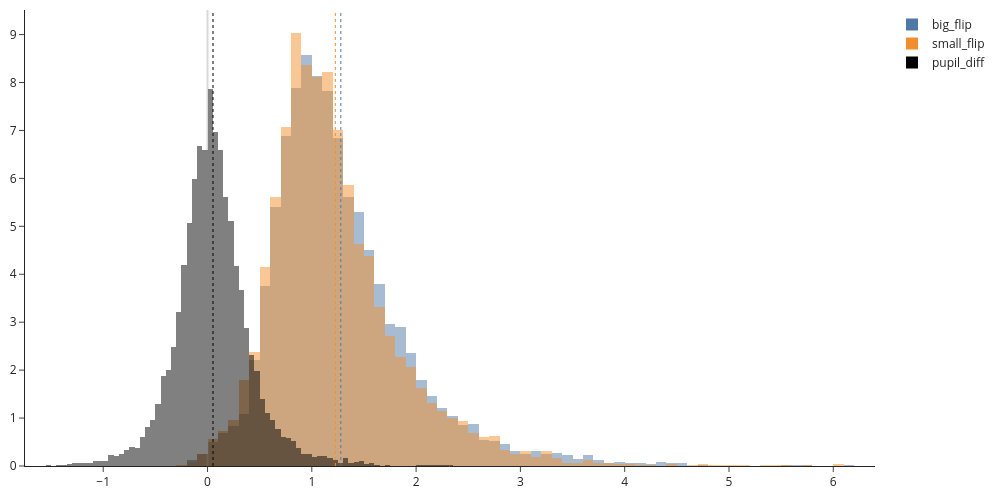

In [11]:
fig = go.Figure()

for source, color in zip(['big_flip', 'small_flip', 'pupil_diff'],
                         [Blue, Orange, 'black']):
    x = toplot[source]
    m = np.mean(x)
    _ = fig.add_trace(go.Histogram(x=x, marker=dict(color=color,
                                                line_width=0,
                                                opacity=0.5),
                               name=source,
                               nbinsx=100,
                               histnorm='percent'))
    _ = fig.add_vline(x=m, line=dict(color=color, dash='dot', width=1), opacity=1)

_ = fig.add_vline(x=0, line=dict(color='gray',width=2, dash='solid'))

_ = fig.update_layout(margin=dict(l=10,r=10,t=10,b=10),
                  template='simple_white',
                  barmode='overlay')


img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

LinregressResult(slope=0.024507886685365937, intercept=-0.008674753212945446, rvalue=0.0845865210417951, pvalue=3.752711663335412e-19, stderr=0.0027351639653229454, intercept_stderr=0.007678856396309259)


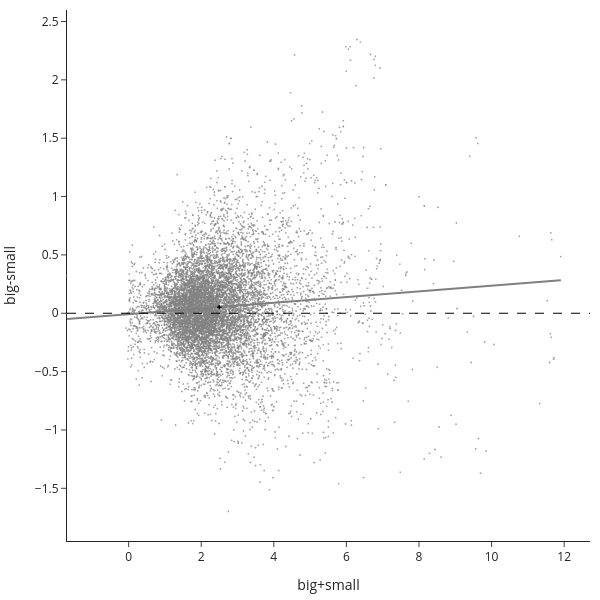

In [12]:
x = (toplot.big_flip + toplot.small_flip).values
y = (toplot.big_flip - toplot.small_flip).values

decimator = np.random.choice(toplot.big_flip.size, int(min([toplot.big_flip.size, 10000])),
                             replace=False)
xd = x[decimator]
yd = y[decimator]

x_title = 'big+small'
y_title = 'big-small'

fig = go.Figure()
# individual markers
_ = fig.add_trace(go.Scattergl(x=xd, y=yd, mode='markers',
                               marker=dict(size=2,
                                           opacity=0.7,
                                           color='gray'),
                               showlegend=False))

# mean of distributions
_ = fig.add_trace(go.Scattergl(x=[xd.mean()], y=[yd.mean()], mode='markers',
                               marker=dict(size=4,
                                           opacity=1,
                                           color='black',
                                           symbol='cross'),
                               showlegend=False))

interval = np.asarray([np.min(np.concatenate([xd, yd])),
                       np.max(np.concatenate([xd, yd]))])

# linear regression, on all data, independent of decimantioon
regression = sst.linregress(x, y)
fig.add_trace(go.Scatter(x= interval,
                         y= regression.intercept + regression.slope * interval,
                         mode='lines',
                         line=dict(dash='solid',
                                   color='gray'),
                         showlegend=False))
fig.add_hline(y=0, line=dict(color='black', width=1, dash='dash'), opacity=1)

# format plot
fig.update_layout(
    template='simple_white',
                  margin=dict(l=50, r=10, t=10, b=50),
                  xaxis=dict(title_text=x_title),
                  yaxis=dict(title_text=y_title))


print(regression)

img_bytes = fig.to_image(format="png", width=600, height=600)
Image(img_bytes)

#  calculate modulation index
and compare directly

In [13]:
pivoted['modulation_index'] = (pivoted['big_flip'] - pivoted['small_flip']) / \
                              (pivoted['big_flip'] + pivoted['small_flip'])

In [14]:
fig = px.box(pivoted, x='chunk', y='modulation_index', color='chunk', facet_col='quality',
             category_orders=dict(quality=['best', 'good', 'bad', 'worst']))
# fig = px.violin(pivoted, x='chunk', y='modulation_index', color='chunk', facet_col='quality')

fig.update_yaxes(range=[-2, 2])

fig.show()

# same for firing rates

In [15]:
def get_filter_DF_marginal():
    # Cluster Mass significant contextual effects
    summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_chunked_amplitude_DF'

    metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D']
    DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                        f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                        f"analysis == 'SC' and "
                                        f"value > 0 and value < 10000")
    DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr', 'analysis'], inplace=True)

    DF['chunk'] = DF['metric'].str.split('_').str[-1]
    DF.loc[:,'chunk'].replace({'integral': 'full'}, inplace=True)

    # creates filter for contextual effects quantiles
    # todo take the mean per probe to broadcast to DF with no context pair information
    signif_filter = DF.query("chunk == 'full'").copy()
    signif_filter[['c0', 'c1']] = signif_filter['context_pair'].str.split('_',expand=True).astype(int)
    signif_filter = pd.melt(signif_filter, id_vars=['id', 'probe', 'chunk', 'value'],
                            value_vars=['c0', 'c1'],  var_name='src_ctx', value_name='context')
    signif_filter = signif_filter.groupby(['id','context','probe','chunk']).agg(value=('value','mean')).reset_index()
    signif_filter['quality'] = pd.qcut(signif_filter['value'].astype(float), q=4,
                                   labels=['worst', 'bad','good', 'best'], retbins=False)

    signif_filter.rename(columns={'value':'mean_integral'}, inplace=True)
    return signif_filter

filter_df_marginal = get_filter_DF_marginal()

In [16]:
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220801_pupil_delta_firerates'
DF_fr = jl.load(fr_DF_file).query("part == 'probe'")

In [17]:
pupil_quality = ['best']
mod_quality = ['best','good','bad','worst']
chunks = ['full']


sel_sites = pup_df.query(f"pupil_quality in {pupil_quality}")['site'].tolist()

# this is a superfluos clasification. Modulation is not relevant to pupil influence in firing rate (not their deltas)
# mod_filter = filter_df_marginal.query(f"quality in {mod_quality} and chunk in {chunks}"
#                              ).loc[:,['id', 'context', 'probe', 'chunk', 'quality']]

filtered = pd.merge(DF_fr.query(f"pupil != 'full' and chunk == 'full'"),
                    pup_df, on=['site'], validate='m:1')
filtered.head()

id     site chunk   part  context  probe       metric  pupil  \
0  CRD018d-01-1  CRD018d  full  probe        0      1  firing_rate  small   
1  CRD018d-01-1  CRD018d  full  probe        0      2  firing_rate  small   
2  CRD018d-01-1  CRD018d  full  probe        0      3  firing_rate  small   
3  CRD018d-01-1  CRD018d  full  probe        0      4  firing_rate  small   
4  CRD018d-01-1  CRD018d  full  probe        1      1  firing_rate  small   

      value        CV pupil_quality  
0  0.249815  0.368401          best  
1 -0.019378  0.368401          best  
2 -0.310398  0.368401          best  
3 -0.208541  0.368401          best  
4  0.024275  0.368401          best

In [ ]:
pivoted = filtered.pivot_table(index=['id', 'context', 'probe', 'chunk', 'pupil_quality', 'CV'],
                             columns='pupil', values='value',
                             aggfunc='first').reset_index()

pivoted['modulation_index'] = (pivoted['big'] - pivoted['small']) / \
                             (pivoted['big'] + pivoted['small'])
# flips by the firing rate independent of pupil
print(pivoted.shape)
pivoted.head(10)

In [ ]:
fig = px.box(
    # toplot.query("modulation_index > -100 and modulation_index < 100"),
    pivoted,
    x='quality', y='modulation_index', color='quality',)

# fig = px.violin(pivoted,
#              x='chunk', y='modulation_index', color='chunk', facet_col='quality')

fig.update_yaxes(range=[-2, 2])

fig.show()
